# Context-Dependent Decision Making Task (Explicit Modality)

This environment implements a context-dependent perceptual decision-making task based on [Mante et al. 2013](https://www.nature.com/articles/nature12742). In this task, the agent receives stimulus inputs from two modalities simultaneously and needs to make a choice based on one modality while ignoring the other. We'll focus on the explicit context version, where:

1. The relevant modality is explicitly signaled on each trial through a context signal
2. The representation uses a ring architecture where choices are represented as angles evenly spaced around a circle. The number of choices can be configured via `dim_ring`. With the default of 2 choices, this corresponds to:

   - Position 1: 0° (left choice)
   - Position 2: 180° (right choice)

For each trial:

- The context signal indicates which modality (0 or 1) is relevant
- The ground truth is randomly chosen to be position 1 or 2 (for 2 choices: left or right)
- Stimulus for each modality is represented as a cosine modulation peaked at one of these positions
- The strength of each modality's signal is controlled by its coherence level
- A context signal explicitly indicates which modality should be used for the correct choice

For example, if the context signal indicates modality 0, the agent must:

- Base its decision on modality 0 (and ignore modality 1)
- Choose position 1 (left) when modality 0's signal peaks at 0°
- Choose position 2 (right) when modality 0's signal peaks at 180°

The key challenge in this version is that the agent must flexibly switch between modalities based on the context signal. This models a fundamental aspect of cognitive flexibility: the ability to dynamically change decision rules based on explicit contextual cues. In the original paper, monkeys were trained to make left/right saccadic eye movements based on either the motion or color of a random dot display, which maps naturally to our two-choice setup. However, the environment's ring architecture supports generalizing to tasks with more than two choices if needed. In this notebook, we will:

1. Train an agent on this task using reinforcement learning with [Stable-Baselines3](https://stable-baselines3.readthedocs.io/)
2. Show how the same problem can be reformulated as a supervised learning task

The key challenge in both approaches is that the agent must learn to flexibly switch between attending to different modalities based on the context signal. This models a key aspect of cognitive flexibility: the ability to dynamically change decision rules based on explicit contextual cues.


# Training an Agent on the Context-Dependent Decision Making Task


## Part 1: Environment Setup and Initial Agent Behavior

First, we need to install `neurogym`, which will handle all the dependencies including Stable-Baselines3. Follow the installation instructions in the [`neurogym` README](https://github.com/neurogym/neurogym?tab=readme-ov-file#installation).

Let's first create and explore the environment using the `ContextDecisionMaking` class from neurogym. We'll use the default configuration for explicit context mode (`use_expl_context = True`) which includes:

- `dim_ring = 2`: Two possible choices (left/right) represented at 0° and 180°
- `timing = {'fixation': 300, 'stimulus': 750, 'delay': ~600, 'decision': 100}` (in milliseconds)
- `rewards = {'abort': -0.1, 'correct': +1.0}`
- `sigma = 0.1`: Standard deviation of the noise added to the inputs

This configuration creates an environment where the agent must switch between attending to different modalities based on an explicit context signal, while using a ring representation for the stimulus and choices.

Note that while we're using `dim_ring = 2` for a basic left/right choice task, the ring architecture can support any number of choices, making it suitable for more complex decision-making scenarios. The environment will provide context signals indicating which modality is relevant for each trial, allowing the agent to flexibly adapt its decision strategy.


Trial timing (in milliseconds):
{'fixation': 300, 'stimulus': 750, 'delay': <neurogym.utils.ngym_random.TruncExp object at 0x13c305a90>, 'decision': 100}

Observation space structure:
Box(-inf, inf, (7,), float32)
Observation components:
{'fixation': 0, 'stim1_mod1': 1, 'stim2_mod1': 2, 'stim1_mod2': 3, 'stim2_mod2': 4, 'context1': 5, 'context2': 6}

Action space structure:
Discrete(3)
Action mapping:
{'fixation': 0, 'choice': [1, 2]}


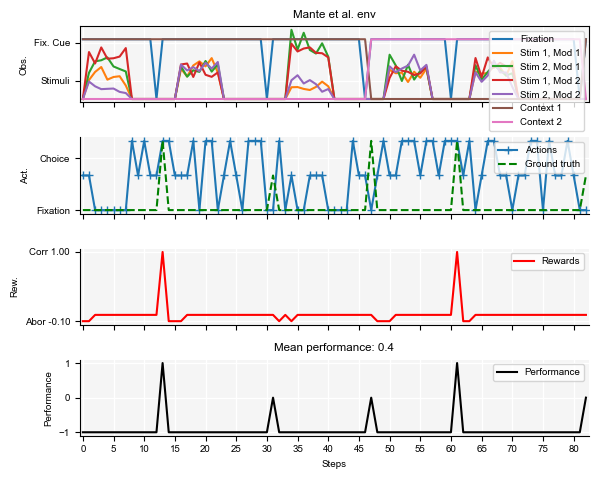

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import neurogym as ngym
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env

# Suppress warnings
warnings.filterwarnings("ignore")

# Environment parameters
EVAL_TRIALS = 1000
use_expl_context = True  # Use explicit context mode
# These are the default values, shown here to demonstrate how they can be modified:
dt = 100
dim_ring = 2  # Number of choices in the ring representation
rewards = {
    "abort": -0.1,
    "correct": +1.0,
    "fail": 0.0
}
timing = {
    "fixation": 300,
    "stimulus": 750,
    "delay": 0,
    "decision": 100,
}
sigma = 1.0

# We can modify any of these parameters by passing them to gym.make():
kwargs = {
    "use_expl_context": use_expl_context,
    # "dt": dt,
    # "dim_ring": dim_ring,
    # "rewards": rewards,
    # "timing": timing,
    # "sigma": sigma,
}

# Create and wrap the environment
task = "ContextDecisionMaking-v0"
env = gym.make(task, **kwargs)

# Check the custom environment and output additional warnings (if any)
check_env(env)

# Test environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # Random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

# Print environment specifications
print("Trial timing (in milliseconds):")
print(env.timing)

print("\nObservation space structure:")
print(env.observation_space)
print("Observation components:")
print(env.observation_space.name)

print("\nAction space structure:")
print(env.action_space)
print("Action mapping:")
print(env.action_space.name)

# Visualize example trials
fig = ngym.utils.plot_env(
    env,
    name='Mante et al.',
    ob_traces=[
        'Fixation',
        'Stim 1, Mod 1',  # First stimulus component of modality 1
        'Stim 2, Mod 1',  # Second stimulus component of modality 1
        'Stim 1, Mod 2',  # First stimulus component of modality 2
        'Stim 2, Mod 2',  # Second stimulus component of modality 2
        'Context 1',      # First context signal
        'Context 2',      # Second context signal
    ],
    num_trials=5
)


Evaluating random policy performance...
Completed 1000/1000 trials

Random policy metrics (1,000 trials):
Mean performance: 0.3370
Mean reward: 0.3370


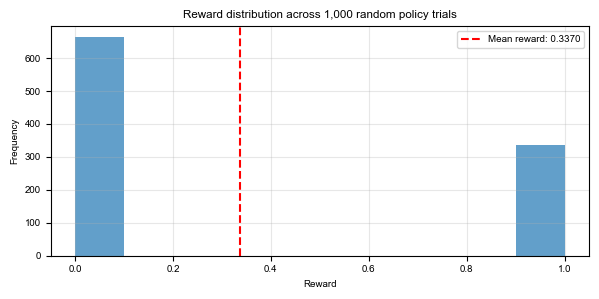

In [2]:
from neurogym.wrappers.monitor import Monitor
# Evaluate performance of the environment before training
eval_monitor = Monitor(
    env
)
print("\nEvaluating random policy performance...")
metrics = eval_monitor.evaluate_policy(num_trials=EVAL_TRIALS)
print(f"\nRandom policy metrics ({EVAL_TRIALS:,} trials):")
print(f"Mean performance: {metrics['mean_performance']:.4f}")
print(f"Mean reward: {metrics['mean_reward']:.4f}")

# Plot reward distribution
plt.figure(figsize=(6, 3))
plt.hist(metrics['rewards'], bins=10, alpha=0.7)
plt.axvline(np.mean(metrics['rewards']), color='r', linestyle='--',
            label=f'Mean reward: {np.mean(metrics["rewards"]):.4f}')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title(f'Reward distribution across {EVAL_TRIALS:,} random policy trials')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Looking at these initial trials with a random agent, we can observe:

- The agent takes arbitrary actions regardless of the stimulus and context presented (random choices)
- It has no understanding that it should switch its attention between modalities based on the context signal
- Performance bounces between 0 (incorrect choices) and 1 (correct choices by chance), with -1 shown during the trial before a choice is made. Note that while it focuses on assessing the cognitive decision-making aspect of the task, it doesn't penalize inappropriate actions made during other periods.

The fixation signal plays a crucial role: when it's high (1), the agent should not make a choice yet but rather maintain fixation (action 0). When the fixation signal drops to 0, this indicates the decision period has begun and the agent should make its choice. While it's possible to enable trial abortion through the `abort` parameter (which would end trials with negative reward if the agent breaks fixation), we keep it disabled by default as it increases computational cost.

Through training, we expect the agent to learn to respect the fixation signal timing, use the context signals to determine the relevant modality, and learn the mapping between signal peaks and appropriate choices in the ring representation. Let's move on to training the agent to see if it can master these key aspects of the task.


## Part 2: Training and Evaluating the Agent

After seeing how a random agent performs, we'll train it using Stable-Baselines3's implementation of PPO (Proximal Policy Optimization). First, let's set up the training infrastructure:

1. `Monitor`: A wrapper that monitors training by:

- Tracking and saving behavioral data (rewards, actions, observations) every `sv_per` steps
- Generating visualization figures during training if `sv_fig=True`
- Providing progress information if `verbose=True`
  This will help us assess the learning process and save intermediate results.

2. `DummyVecEnv`: A Stable-Baselines3 wrapper that converts our environment into a vectorized form (required by PPO), even though we're only using a single environment instance.

Let's train our agent:


In [3]:
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Set the number of trials to train on
avg_timesteps = env.avg_timesteps_per_trial
TRAIN_TRIALS = 10000  # Choose the desired number of trials
total_timesteps = int(TRAIN_TRIALS * avg_timesteps)
print(f"Training for {TRAIN_TRIALS:,} trials ≈ {total_timesteps:,} timesteps")

# Configure monitoring with trial-appropriate parameters
trials_per_figure = 10  # Show 10 trials in each figure
steps_per_figure = int(trials_per_figure * avg_timesteps)

train_monitor = Monitor(
    env,
    folder="./training_logs/",
    sv_per=1000,         # Save data every 1000 trials
    sv_stp="trial",      # Save based on completed trials
    verbose=True,        # Print stats when data is saved
    sv_fig=True,         # Save visualization figures
    num_stps_sv_fig=steps_per_figure, # Number of steps per figure
    name="training_run"  # Name prefix for files
)
env_vec = DummyVecEnv([lambda: train_monitor])

# Create and train Recurrent PPO agent
# Set n_steps to be a multiple of your average trial length
trials_per_batch = 64
n_steps = int(avg_timesteps * trials_per_batch)  # Collect approximately 64 trials per update
batch_size = 32  # Smaller batch size for short episodes
policy_kwargs = {
    "lstm_hidden_size": 64,  # Smaller LSTM for short sequences
    "n_lstm_layers": 1,      # Single layer is sufficient
    "shared_lstm": True,     # Share LSTM to reduce parameters
    "enable_critic_lstm": False,  # Disable separate LSTM for critic when sharing
}
rl_model = RecurrentPPO(
    "MlpLstmPolicy",
    env_vec,
    learning_rate=5e-4,       # Slightly higher for faster learning in short episodes
    n_steps=n_steps,          # Align with multiple complete episodes
    batch_size=32,            # Smaller batch size
    ent_coef=0.01,            # Promote exploration
    policy_kwargs=policy_kwargs,
    verbose=1
)

rl_model.learn(total_timesteps=total_timesteps, log_interval=int(total_timesteps/10))
env_vec.close()

Training for 10,000 trials ≈ 175,000 timesteps
Using cpu device
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_1000.npz
Number of trials: 1000
Average reward: 0.436
Average performance: 0.436
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_2000.npz
Number of trials: 2000
Average reward: 0.494
Average performance: 0.494
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_3000.npz
Number of trials: 3000
Average reward: 0.561
Average performance: 0.561
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_4000.npz
Number of trials: 4000
Average reward: 0.722
Average performance: 0.722
--------------------
--------------------
Data saved to: training_logs/ContextDecisionMaking_bhvr_data_training_run_5000.npz
Number of trials: 5000
Average reward: 0.774

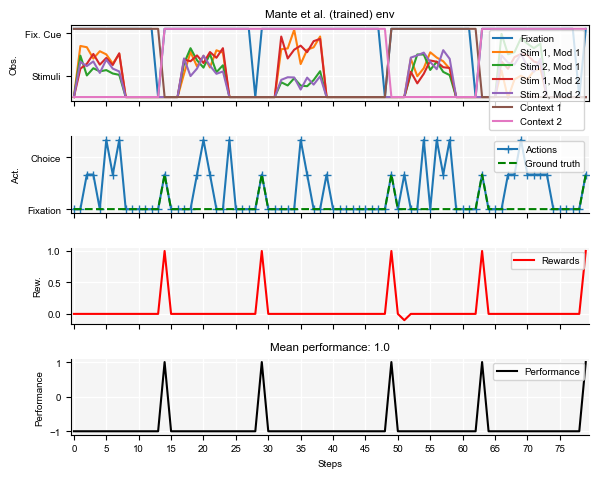

In [7]:
# Plot example trials with trained agent
fig = ngym.utils.plot_env(
    env_vec,
    name='Mante et al. (trained)',
    ob_traces=[
        'Fixation',
        'Stim 1, Mod 1',  # First stimulus component of modality 1
        'Stim 2, Mod 1',  # Second stimulus component of modality 1
        'Stim 1, Mod 2',  # First stimulus component of modality 2
        'Stim 2, Mod 2',  # Second stimulus component of modality 2
        'Context 1',      # First context signal
        'Context 2',      # Second context signal
    ],
    num_trials=5,
    model=rl_model,
)

After training, we visualize the agent's behavior on a few example trials. In contrast to the random agent, we should now see:

- Consistent fixation maintenance during the fixation period
- Choices that correlate with the evidence in the modality indicated by the context signal
- No systematic relationship between choices and signals from the irrelevant modality
- Performance significantly above chance level (0.5), reflecting successful context-dependent decisions

The plot shows the trained agent's behavior across 5 example trials, allowing us to visualize how well it has learned to flexibly switch its attention between modalities based on the context signal and make appropriate choices using the ring representation.


Found 9 data files
Figure saved to training_logs/ContextDecisionMaking_training_history.png


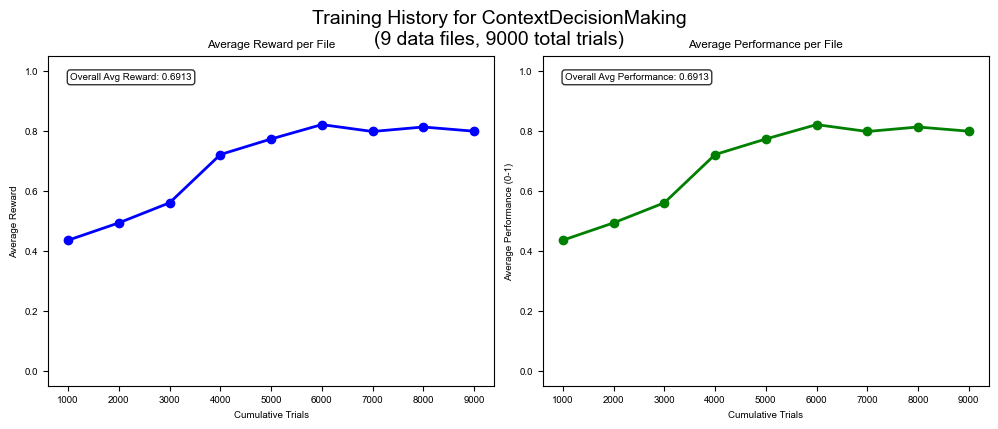

In [8]:
fig = train_monitor.plot_training_history(figsize=(10, 4))


Evaluating trained model performance...
Completed 1000/1000 trials

Trained model metrics (1,000 trials):
Mean performance: 0.9100
Mean reward: 0.9100


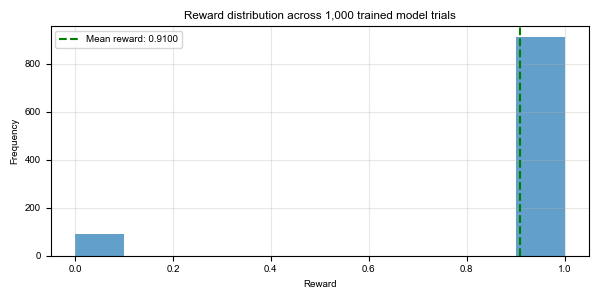

In [9]:
# Evaluate performance of the trained model
print("\nEvaluating trained model performance...")
rl_trained_metrics = eval_monitor.evaluate_policy(num_trials=EVAL_TRIALS, model=rl_model)
print(f"\nTrained model metrics ({EVAL_TRIALS:,} trials):")
print(f"Mean performance: {rl_trained_metrics['mean_performance']:.4f}")
print(f"Mean reward: {rl_trained_metrics['mean_reward']:.4f}")

# Plot reward distribution
plt.figure(figsize=(6, 3))
plt.hist(rl_trained_metrics['rewards'], bins=10, alpha=0.7)
plt.axvline(np.mean(rl_trained_metrics['rewards']), color='g', linestyle='--',
            label=f'Mean reward: {np.mean(rl_trained_metrics["rewards"]):.4f}')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title(f'Reward distribution across {EVAL_TRIALS:,} trained model trials')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Learning the Task as a Supervised Problem


## Part 1: Converting the Environment to a Supervised Dataset


In [86]:
# Sample trials to understand the distribution
num_samples = 10000
trial_lengths = []

for _ in range(num_samples):
    env.new_trial()
    trial_lengths.append(env.ob.shape[0])  # Length of current trial

trial_lengths = np.array(trial_lengths)
avg_timesteps = np.mean(trial_lengths)
std_dev = np.std(trial_lengths)
max_length = np.max(trial_lengths)
percentile_95 = np.percentile(trial_lengths, 95)

print(f"Average timesteps per trial: {avg_timesteps:.2f} ± {std_dev:.2f}")
print(f"Maximum trial length: {max_length}")
print(f"95th percentile length: {percentile_95}")

# Set seq_len to capture 95% of trials
seq_len = round(percentile_95)
print(f"Using sequence length: {seq_len}")

Average timesteps per trial: 19.26 ± 5.28
Maximum trial length: 40
95th percentile length: 30.0
Using sequence length: 30


NOTE: The standard `Dataset` class will truncate trials longer than `seq_len`, which might affect learning. Are we okay with it? What's the advised strategy in such cases? Should we edit `Dataset` to preserve complete trials by padding shorter ones and ensuring longer ones are processed completely?

Example: if `seq_len` is 30, each call to `dataset()` will return 30 timesteps worth of data for each element in the batch, but those timesteps might span across trial boundaries in the cache.
However, in LSTM training we generally want the model to see complete trials rather than fragments of trials stitched together. If we set `seq_len` greater than or equal to the maximum trial length, we ensure each sequence contains at most one trial boundary. But still, it might not be the best approach.


In [90]:
import torch.nn as nn
import torch

# Environment parameters
task = 'ContextDecisionMaking-v0'
kwargs = {
    "use_expl_context": use_expl_context,
    # "dt": dt,
    # "dim_ring": dim_ring,
    # "rewards": rewards,
    # "timing": timing,
    # "sigma": sigma,
}

# Make supervised dataset
print(f"Creating dataset with batch_size={batch_size}")
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)

env = dataset.env

# Extract dimensions from environment
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

print(f"Observation size: {ob_size}")
print(f"Action size: {act_size}")

# Get a batch of data
inputs, target = dataset()

# Display shapes and content
print(f"Input batch shape: {inputs.shape}")
print(f"Target batch shape: {target.shape}")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Creating dataset with batch_size=32
Observation size: 7
Action size: 3
Input batch shape: (30, 32, 7)
Target batch shape: (30, 32)
Using device: cpu


In [98]:
print(dataset._cache_len)
print(dataset.max_batch)
dataset._inputs.shape

420
inf


(420, 32, 7)

In [91]:
# Define the LSTM model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # Forward pass with hidden state tracking
        lstm_out, hidden = self.lstm(x, hidden)
        output = self.fc(lstm_out)
        return output, hidden

    def init_hidden(self, batch_size, device):
        """Initialize hidden state"""
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        return (h0, c0)

# Create the model
hidden_size = 128
sl_model = Net(
    input_size=ob_size,
    hidden_size=hidden_size,
    output_size=act_size,
).to(device)

## Part 2: Training and Evaluating a Neural Network Model


Epoch [0/500], Loss: 1.0179
Epoch [50/500], Loss: 0.0940
Epoch [100/500], Loss: 0.0429
Epoch [150/500], Loss: 0.0382
Epoch [200/500], Loss: 0.0396
Epoch [250/500], Loss: 0.0333
Epoch [300/500], Loss: 0.0370
Epoch [350/500], Loss: 0.0251
Epoch [400/500], Loss: 0.0416
Epoch [450/500], Loss: 0.0347
Finished Training


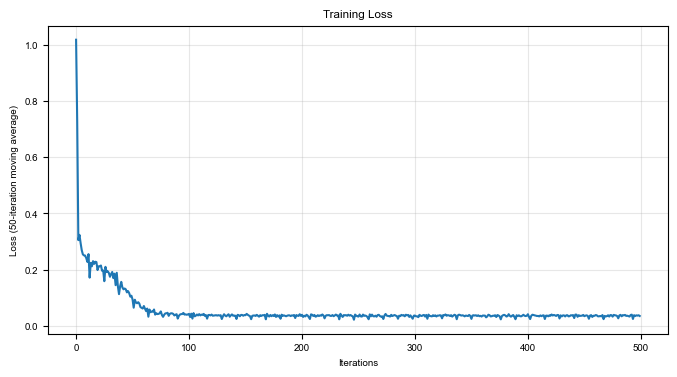

In [92]:
optimizer = torch.optim.Adam(sl_model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
EPOCHS = 500
# Training loop
loss_history = []

for i in range(EPOCHS):
    # Get a batch of data
    inputs, targets = dataset()

    # Convert to PyTorch tensors
    inputs = torch.from_numpy(inputs).float().to(device)
    targets = torch.from_numpy(targets).long().to(device)

    # Initialize hidden state
    hidden = sl_model.init_hidden(inputs.size(1), device)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass with hidden state tracking
    outputs, _ = sl_model(inputs, hidden)

    # Reshape for CrossEntropyLoss
    outputs_flat = outputs.reshape(-1, outputs.size(2))
    targets_flat = targets.reshape(-1)

    # Calculate loss
    loss = criterion(outputs_flat, targets_flat)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    # print statistics
    loss_history.append(loss.item())
    if i % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(i, EPOCHS, loss.item()))

print('Finished Training')

# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (50-iteration moving average)')
plt.grid(True, alpha=0.3)
plt.show()

In [94]:
# Evaluate performance of the trained model
sl_model.eval()

total_correct = 0
total_trials = 0

# Evaluate for specified number of trials
print(f"Evaluating model performance across {EVAL_TRIALS} trials...")

for i in range(EVAL_TRIALS):
    # Generate a new trial
    env.new_trial()
    ob, gt = env.ob, env.gt
    # print("observation shape:", ob.shape)
    # print("ground truth shape:", gt.shape)

    # Handle potentially variable-length trials
    trial_length = ob.shape[0]

    # Add batch dimension to observation
    ob = ob[:, np.newaxis, :]

    # Convert to tensor
    inputs = torch.from_numpy(ob).float().to(device)
    # print("inputs shape:", inputs.shape)

    # Initialize hidden state for new trial
    hidden = sl_model.init_hidden(1, device)

    with torch.no_grad():
        outputs, _ = sl_model(inputs, hidden)
        # print("outputs shape:", outputs.shape)
        pred_actions = torch.argmax(outputs, dim=2)
        # print("predicted actions shape:", pred_actions.shape)
        # print("predicted actions:", pred_actions)
        # print("ground truth:", gt)

    # Check only the decision period
    decision_idx = trial_length - 1  # Assuming decision is at the end
    is_correct = (gt[decision_idx] == pred_actions[decision_idx, 0].cpu().numpy())
    # print(is_correct)

    total_correct += is_correct

    if (i+1) % 100 == 0:
        print(f"Completed {i+1}/{EVAL_TRIALS} trials | Accuracy: {total_correct/(i+1):.4f}")

# Calculate mean performance
sl_mean_performance = total_correct / EVAL_TRIALS

print(f"Mean performance across {EVAL_TRIALS} trials: {sl_mean_performance:.4f}")

Evaluating model performance across 1000 trials...
Completed 100/1000 trials | Accuracy: 0.5100
Completed 200/1000 trials | Accuracy: 0.5300
Completed 300/1000 trials | Accuracy: 0.5267
Completed 400/1000 trials | Accuracy: 0.5175
Completed 500/1000 trials | Accuracy: 0.5120
Completed 600/1000 trials | Accuracy: 0.5083
Completed 700/1000 trials | Accuracy: 0.5100
Completed 800/1000 trials | Accuracy: 0.5075
Completed 900/1000 trials | Accuracy: 0.5067
Completed 1000/1000 trials | Accuracy: 0.5130
Mean performance across 1000 trials: 0.5130


# Comparing RL and SL Approaches


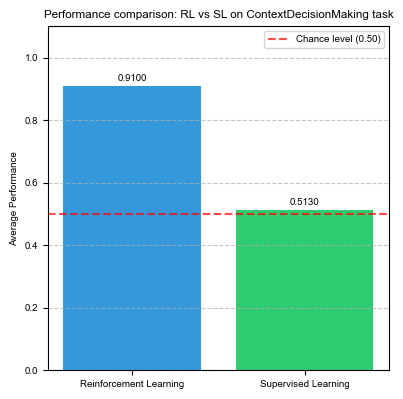

RL model performance: 0.9100
SL model performance: 0.5130
Difference (RL - SL): 0.3970


In [95]:
rl_performance = rl_trained_metrics['mean_performance']
sl_performance = sl_mean_performance

# Create a simple bar plot to compare performances
plt.figure(figsize=(4, 4))
models = ['Reinforcement Learning', 'Supervised Learning']
performances = [rl_performance, sl_performance]

# Create bar plot
bars = plt.bar(models, performances, color=['#3498db', '#2ecc71'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

# Customize plot
plt.ylim(0, 1.1)  # Performance ranges from 0 to 1
plt.ylabel('Average Performance')
plt.title('Performance comparison: RL vs SL on ContextDecisionMaking task')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at chance level performance (if applicable)
chance_level = 1.0 / (act_size - 1)  # Assuming fixation (action 0) doesn't count for performance
plt.axhline(y=chance_level, linestyle='--', color='red', alpha=0.7,
            label=f'Chance level ({chance_level:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

# Print numerical comparison
print(f"RL model performance: {rl_performance:.4f}")
print(f"SL model performance: {sl_performance:.4f}")
print(f"Difference (RL - SL): {rl_performance - sl_performance:.4f}")